<h1 style="text-align: center;">Data Science Project</h1>
<h2 style="text-align: center;">Part 3</h2>
<h2 style="text-align: center;">EDA of Udemy Courses and ML to Predict Subscribers</h2>

In [1]:
# common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas imports
from pandas.plotting import scatter_matrix

# machine learning imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics

# display setup
pd.set_option("display.max_columns", None) # the None parameter displays unlimited columns
sns.set(style="whitegrid") # for plots

## 1. Getting the Data

In [2]:
# read the csv file
df = pd.read_csv("udemy_courses.csv")

In [3]:
# display the first 5 rows for a quick look
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


In [4]:
# DataFrame shape (rows, columns)
# understand the amount of data we are working with
df.shape

(3678, 12)

In [5]:
# description of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3678 non-null   int64  
 1   course_title         3678 non-null   object 
 2   url                  3678 non-null   object 
 3   is_paid              3678 non-null   bool   
 4   price                3678 non-null   int64  
 5   num_subscribers      3678 non-null   int64  
 6   num_reviews          3678 non-null   int64  
 7   num_lectures         3678 non-null   int64  
 8   level                3678 non-null   object 
 9   content_duration     3678 non-null   float64
 10  published_timestamp  3678 non-null   object 
 11  subject              3678 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 319.8+ KB


In [6]:
# check if there are null values
df.isna().sum()

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

In [7]:
# summary of the numerical attributes
df.describe()

,course_id,price,num_subscribers,num_reviews,num_lectures,content_duration
count,3.678000e+03,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000
mean,6.759720e+05,66.049483,3197.150625,156.259108,40.108755,4.094517
std,3.432732e+05,61.005755,9504.117010,935.452044,50.383346,6.053840
min,8.324000e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.076925e+05,20.000000,111.000000,4.000000,15.000000,1.000000
50%,6.879170e+05,45.000000,911.500000,18.000000,25.000000,2.000000
75%,9.613555e+05,95.000000,2546.000000,67.000000,45.750000,4.500000
max,1.282064e+06,200.000000,268923.000000,27445.000000,779.000000,78.500000


> As shown above, there are no missing values which is excellent!
>
> ##### *It is vital to understand the features we are working with.*
> ### Features in the DataFrame:
>> 1. course_id: Course identification number
>> 2. course_title: Title of course
>> 3. url: Course URL
>> 4. is_paid: True if the course costs money, false if the course is free
>> 5. price: Price of course
>> 6. num_subscribers: Number of subscribers for the course
>> 7. num_lectures: Number of lectures in the course
>> 8. level: Difficulty level of the course
>> 9. content_duration: Duration of all course materials
>> 10. published_timestamp: Course publication date
>> 11. subject: Subject of course

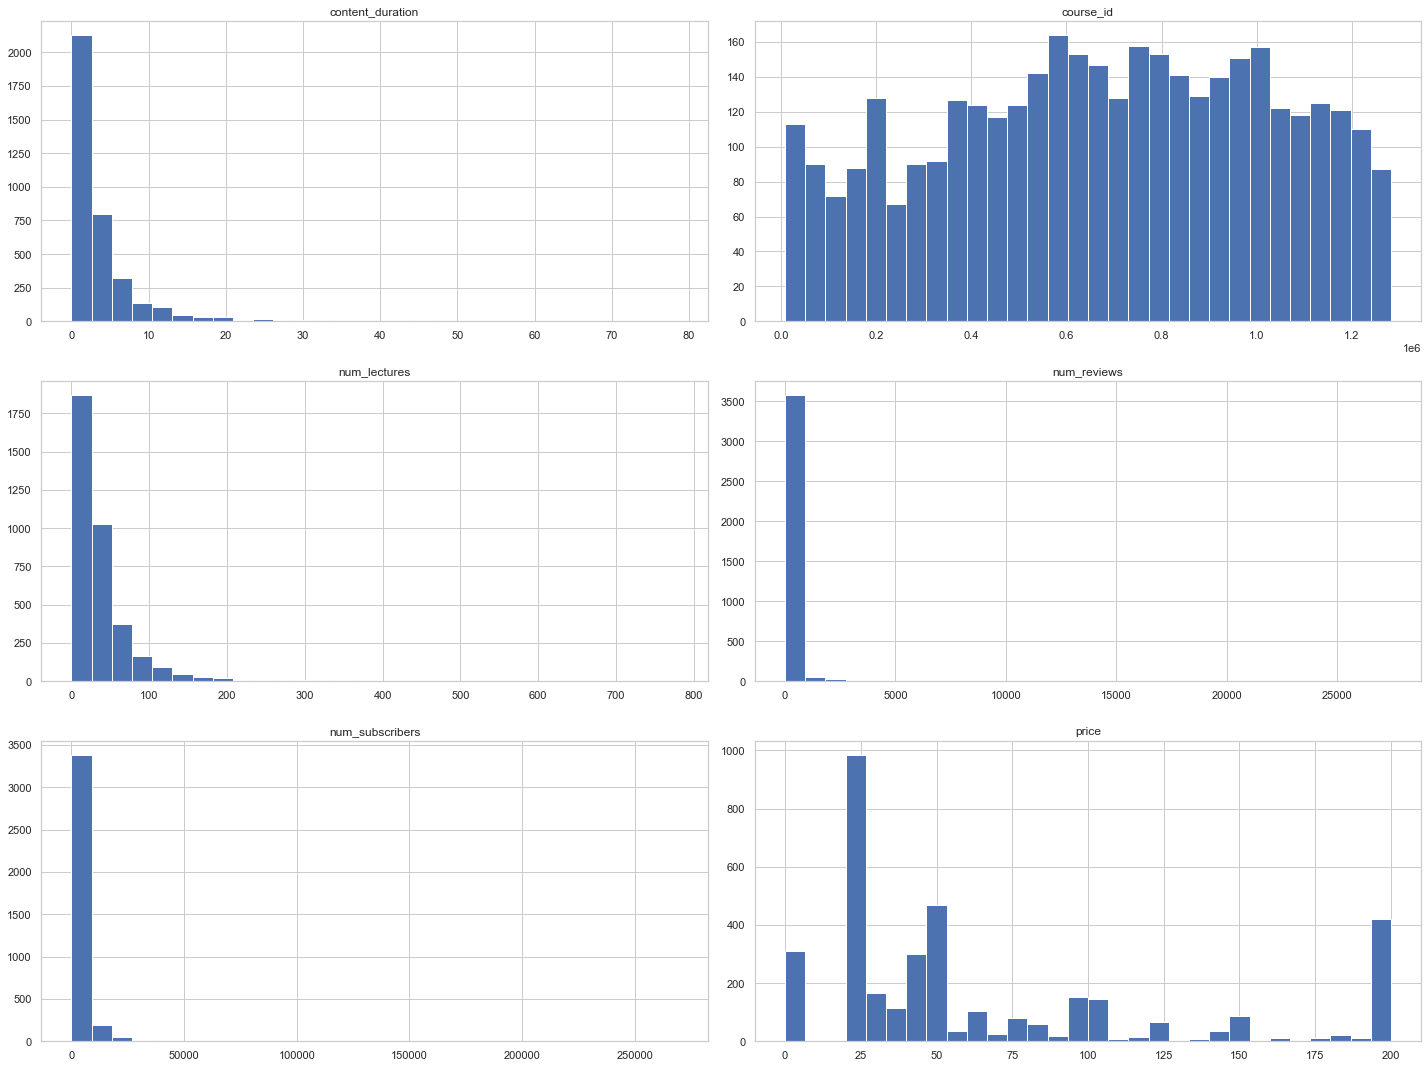

In [8]:
# a histogram plot for each numerical attribute
df.drop("is_paid", axis=1).hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
>> 1. Most course durations are between 0-5 hours.
>> 2. There are usually around 1-50 lectures per course.
>> 3. Courses tend to have few reviews. There are probably a handful of courses
>> with a large amount of reviews since the X axis goes up to 25000 while over 3000
>> instances are represented in the first bin.
>> 4. The majority of courses are in the same range of subscribers. The instances farther up
>> the scale were probably more successful or perhaps courses on a trending topic.
>> 5. Assuming the prices are in USD, the range is between 0-250 dollars.
>> The plot shows the most common price roughly $25.

> # Objective:
> ## Predicting the number of subscribers for a course.
>> ### Chosen Feature:
>> #### *num_subscribers* column
>>> The column represents how many people have subscribed to each course.
>>> ### Motive:
>>> Predicting the number of people subscribed to a course, course popularity.

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [9]:
# use sklearn train_test_split function to split the data
# the random state parameter ensures that data will be shuffled and split the same way in each run
train_set, test_set = train_test_split(df, test_size=0.20, random_state=42)

In [10]:
print("Number of instances in training set: ", len(train_set))
print("Number of instances in testing set: ", len(test_set))

Number of instances in training set:  2942
Number of instances in testing set:  736


## 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights*

In [11]:
# deep copy of the training set
df2 = train_set.copy()

In [12]:
df2.head(2)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
2490,1146014,Learn JavaScript for beginners,https://www.udemy.com/learn-javascript-course/,True,200,15276,167,19,Beginner Level,1.5,2017-03-16T20:57:12Z,Web Development
2886,241590,Make a professional website - 30 Day Guarantee...,https://www.udemy.com/make-your-own-business-w...,True,20,11167,34,13,All Levels,2.0,2014-06-23T16:03:41Z,Web Development


> ## Exploring Attribute Combinations

In [13]:
# method creates a correlations matrix
corr_matrix = df2.corr()

In [14]:
# looking at attributes correlation with num_subscribers feature
corr_matrix["num_subscribers"].sort_values(ascending=False)

num_subscribers     1.000000
num_reviews         0.641087
num_lectures        0.164072
content_duration    0.161800
price               0.046734
course_id          -0.168235
is_paid            -0.270822
Name: num_subscribers, dtype: float64

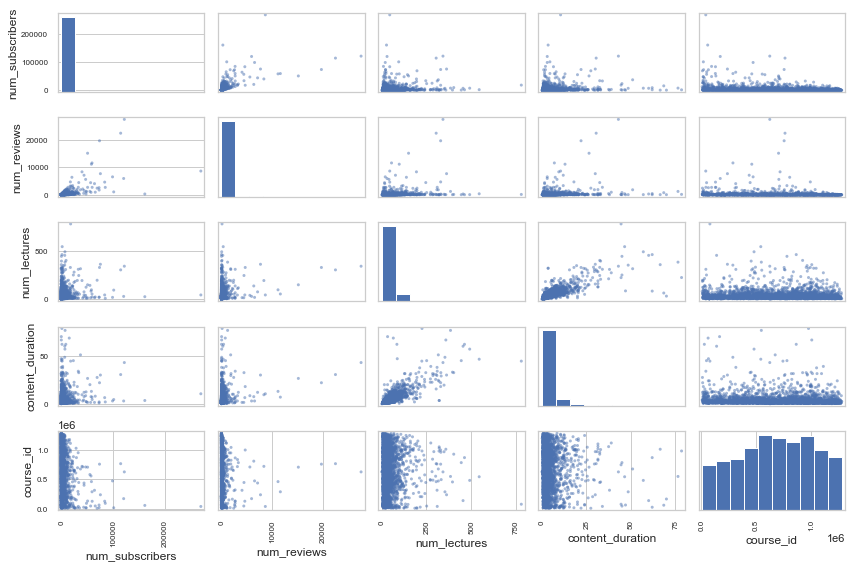

In [15]:
# a histogram plot for attributes with a high correlation

attributes = ["num_subscribers", "num_reviews", "num_lectures",
              "content_duration", "course_id"]

scatter_matrix(df2[attributes], figsize=(12,8))
plt.tight_layout()
plt.show()

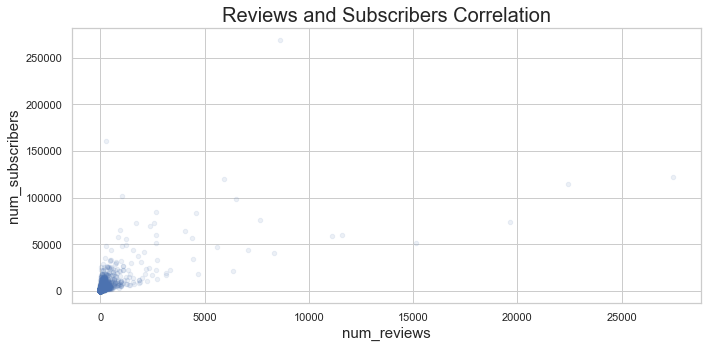

In [16]:
# scatter plot of the strongest correlation in the corr matrix
# the alpha is set to show the distribution more clearly
df2.plot(kind="scatter", x="num_reviews", y="num_subscribers", alpha=0.1,
         color='b', figsize=(10,5))
plt.title("Reviews and Subscribers Correlation", size=20)
plt.xlabel("num_reviews", size=15)
plt.ylabel("num_subscribers", size=15)
plt.tight_layout()
plt.show()

> ### Correlations with num_subscribers Attribute- Overview:
> The strongest positive correlations (0.1 or more) are:
> * num_reviews
> * num_lectures
> * content_duration
>
> The strongest negative correlations (-0.1 or less) are:
> * course_id
> * is_paid

> ### Examining Course ID Feature

In [17]:
print("Number of unique course IDs:", df2["course_id"].nunique())
print("Length of DataFrame:", len(df2))

Number of unique course IDs: 2939
Length of DataFrame: 2942


In [18]:
# check if number of unique urls
# should be individual for each instance
df2["url"].nunique()

2939

> Since there is a unique value for almost every course ID, the correlation was probably
> coincidental.

In [19]:
# show duplicated listings
df2[df2.duplicated("course_id")]

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
454,1157298,Introduction to Forex Trading Business For Beg...,https://www.udemy.com/introduction-to-forex-tr...,True,20,0,0,27,Beginner Level,1.500000,2017-04-23T16:19:01Z,Business Finance
1473,185526,MicroStation - Células,https://www.udemy.com/microstation-celulas/,True,20,0,0,9,Beginner Level,0.616667,2014-04-15T21:48:55Z,Graphic Design
894,1035638,Understanding Financial Statements,https://www.udemy.com/understanding-financial-...,True,25,0,0,10,All Levels,1.000000,2016-12-15T14:56:17Z,Business Finance


In [20]:
# remove duplicated listings
df2.drop_duplicates(inplace=True)

In [21]:
# examine changes
df2.shape

(2939, 12)

> ### Overview:
> * The course ID is unique for each course.
> * This column should be removed when training a model in order to generalize better.

> ### Assessing Price Features

In [22]:
# evaluate current values in column
df2["is_paid"].head(10)

2490     True
2886     True
3198     True
2899     True
1053     True
2554     True
2990     True
1904     True
67       True
1846    False
Name: is_paid, dtype: bool

In [23]:
# use encoder to convert "is_paid" column to binary outcome
ordinal_encoder = OrdinalEncoder(dtype=int)
df2["is_paid"] = ordinal_encoder.fit_transform(df2[["is_paid"]])

In [24]:
# evaluate changes
df2["is_paid"].head(10)

2490    1
2886    1
3198    1
2899    1
1053    1
2554    1
2990    1
1904    1
67      1
1846    0
Name: is_paid, dtype: int32

In [25]:
# 0 is False, 1 is True
ordinal_encoder.categories_

[array([False,  True])]

In [26]:
# count number of instances for each outcome
df2["is_paid"].value_counts()

1    2700
0     239
Name: is_paid, dtype: int64

In [27]:
# use groupby for price attribute
price_values = df2.groupby("price")

In [28]:
# check if number of free courses matches when the price is 0
price_values_0 = price_values.get_group(0)
price_values_0.shape

(239, 12)

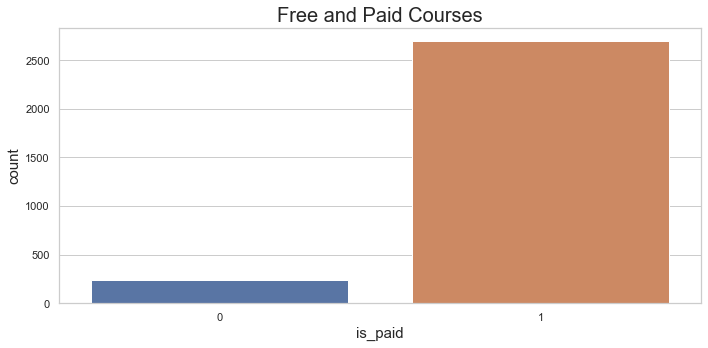

In [29]:
# plot of free and paid courses
plt.figure(figsize=(10,5))
sns.countplot(x=df2["is_paid"])
plt.title("Free and Paid Courses", size=20)
plt.xlabel("is_paid", size = 15)
plt.ylabel("count", size=15)
plt.tight_layout()
plt.show()

In [30]:
# course price values sorted by prices
df2["price"].value_counts().sort_index()

0      239
20     672
25     122
30     133
35      94
40     173
45      63
50     376
55      27
60      64
65      23
70      23
75      65
80      24
85      28
90      14
95     119
100    105
105     10
110      8
115     13
120     30
125     20
130      2
135      7
140      5
145     21
150     67
155      2
160      4
165      5
170      5
175     10
180     15
185      5
190      9
195    100
200    237
Name: price, dtype: int64

In [31]:
# top ten course price values sorted by value counts
prices_top10 = df2["price"].value_counts().sort_values(ascending=False).head(10)

In [32]:
# calculate percentage of instances per price in data
prices_percent_in_data = []
num_subscribed = []

for i in range(len(prices_top10.index)):
    prices_percent_in_data.append(round((prices_top10.values[i]/len(df2))*100,2))
    num_subscribed.append(price_values.get_group(prices_top10.index[i])["num_subscribers"].sum())

In [33]:
# create a DataFrame with the results
prices_top10_dict = {"price": prices_top10.index, "number_of_instances": prices_top10.values,
                     "% of data": prices_percent_in_data, "num_subscribers": num_subscribed}
prices_top10_df = pd.DataFrame(prices_top10_dict, index=range(1,11))
prices_top10_df

,price,number_of_instances,% of data,num_subscribers
1,20,672,22.86,1086051
2,50,376,12.79,592522
3,0,239,8.13,2969312
4,200,237,8.06,1095015
5,40,173,5.89,169486
6,30,133,4.53,247634
7,25,122,4.15,133833
8,95,119,4.05,255956
9,100,105,3.57,331746
10,195,100,3.40,799940


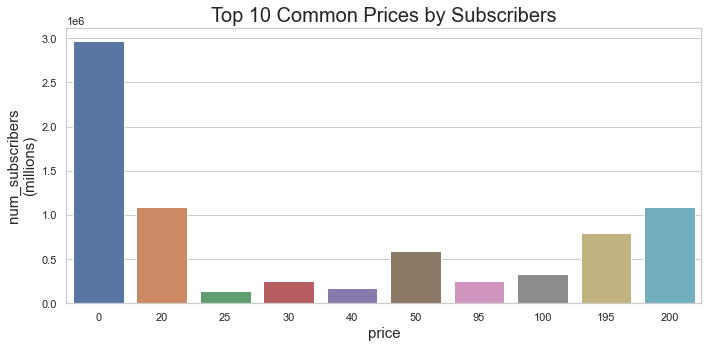

In [34]:
# plot of top 10 common prices by amount of subscribers
plt.figure(figsize=(10,5))
sns.barplot(x=prices_top10_df["price"], y=prices_top10_df["num_subscribers"])
plt.xlabel("price", size=15)
plt.ylabel("num_subscribers\n(millions)", size=15)
plt.title("Top 10 Common Prices by Subscribers", size=20)
plt.tight_layout()
plt.show()

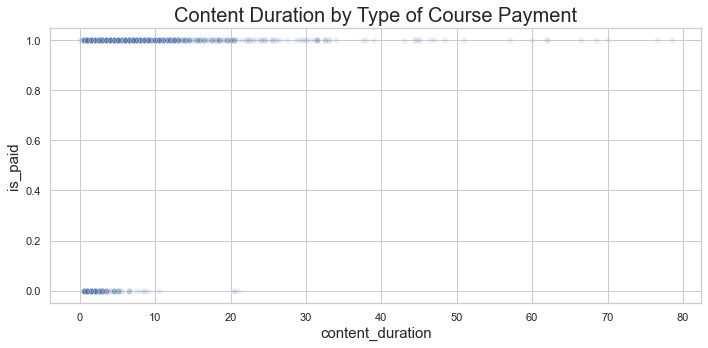

In [35]:
# plot of content duration by free or paid course
plt.figure(figsize=(10,5))
sns.scatterplot(x=df2["content_duration"], y=df2["is_paid"], alpha=0.1)
plt.title("Content Duration by Type of Course Payment", size=20)
plt.xlabel("content_duration", size=15)
plt.ylabel("is_paid", size=15)
plt.tight_layout()
plt.show()

> ### Observations:
> * As speculated earlier in the initial observations, $20 is the most common price for a course.
> * The number of listings with the price $0 matches the number of instances that were
> labeled "False" in the is_paid column.
> * The prices listed tend to increase by 5 dollars until they reach the maximum price
> which is $200.
> * Amongst the 10 most common prices in the data, most are subscribed to the free courses.
> * Content duration is longer for paid courses.

> ### Researching Level and Subject Features

In [36]:
# count number of instances
level_values = df2["level"].value_counts()
level_values

All Levels            1536
Beginner Level        1018
Intermediate Level     332
Expert Level            53
Name: level, dtype: int64

In [37]:
# count number of instances
subject_values = df2["subject"].value_counts()
subject_values

Web Development        968
Business Finance       929
Musical Instruments    553
Graphic Design         489
Name: subject, dtype: int64

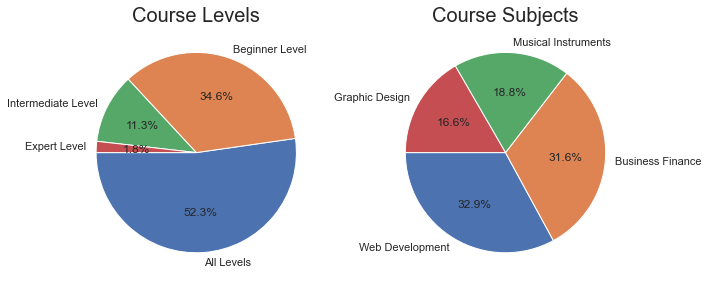

In [38]:
# pie plot of course levels and subjects in data
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pie(level_values, startangle=180, labels=level_values.index, autopct="%1.1f%%")
ax[0].set_title("Course Levels", size=20)
ax[1].pie(subject_values, startangle=180, labels=subject_values.index, autopct="%1.1f%%")
ax[1].set_title("Course Subjects", size=20)
plt.tight_layout()
plt.show()

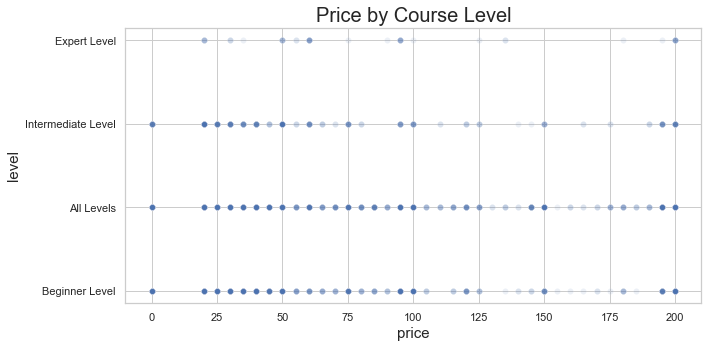

In [39]:
# scatter plot of price by course level
plt.figure(figsize=(10,5))
sns.scatterplot(y=df2["level"], x=df2["price"], alpha=0.1)
plt.title("Price by Course Level", size=20)
plt.xlabel("price", size=15)
plt.ylabel("level", size=15)
plt.tight_layout()
plt.show()

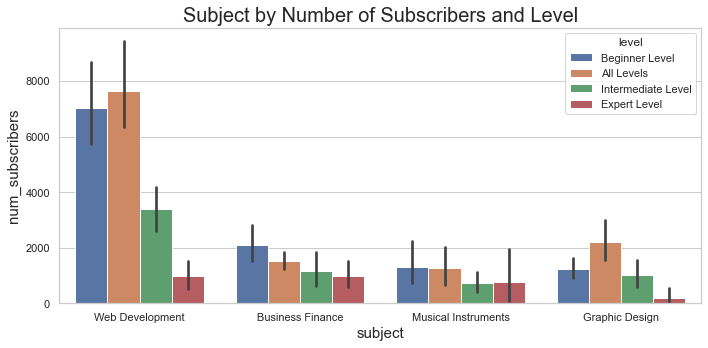

In [40]:
# plot subject by number of subscribers and level
# the black bars represent the error
plt.figure(figsize=(10,5))
sns.barplot(x=df2["subject"], y=df2["num_subscribers"], hue=df2["level"])
plt.title("Subject by Number of Subscribers and Level", size=20)
plt.xlabel("subject", size=15)
plt.ylabel("num_subscribers", size=15)
plt.tight_layout()
plt.show()

> ### Observations:
> * All Levels is the most common level, representing over 50%.
> * Web Development is the most common subject, and Business Finance is second with
> approximately a 1% differential.
> * Price variations according to the level of the course also show that Expert is
> the least common level in the data. It is also the only level that does not
> provide free courses. The other levels are dispersed more frequently
> throughout the line.
> * Web Development courses are significantly higher in subscribers than the other subjects.
> Since Business Finance falls shortly behind in content, it is likely that people are more
> interested in studying Web Development courses.

> ### Analyzing Additional Columns

In [41]:
# examine current shape
df2.shape

(2939, 12)

In [42]:
# every course has a unique URL
df2["url"].nunique()

2939

In [43]:
# some courses have an identical title
df2["course_title"].nunique()

2930

In [44]:
# find duplicated instances
# false marks all duplicates as true
title_df = df2[df2.duplicated("course_title", keep=False)].copy()
# show duplicated titles
title_df["course_title"].unique()

array(['Acoustic Blues Guitar Lessons',
       'Creating an animated greeting card via Google Slides',
       'The Complete Web Developer Masterclass: Beginner To Advanced',
       'How to Make a Wordpress Website 2017',
       'Drum Lessons For Beginners', 'Introduction to Web Development',
       'Aprende a tocar el acordeón de botones'], dtype=object)

In [45]:
# examine number of unique subscribers values
title_df["num_subscribers"].nunique()

16

In [46]:
# groupy course title
title = title_df.groupby("course_title")

In [47]:
# examining one of the duplicated courses
# the courses have the same name and different values for some features
title.get_group("Acoustic Blues Guitar Lessons")

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
2067,112314,Acoustic Blues Guitar Lessons,https://www.udemy.com/jim-bruce-blues-guitar-l...,1,125,1284,136,40,Intermediate Level,12.5,2013-11-28T08:54:00Z,Musical Instruments
2158,647276,Acoustic Blues Guitar Lessons,https://www.udemy.com/acoustic-blues-guitar-le...,1,75,189,18,101,Intermediate Level,4.5,2016-01-10T21:39:42Z,Musical Instruments
2062,99324,Acoustic Blues Guitar Lessons,https://www.udemy.com/finger-picking-blues-gui...,0,0,8217,109,10,Intermediate Level,1.0,2013-09-30T20:45:20Z,Musical Instruments


> ### Observations:
> * The duplicated courses have different parameters such as is_paid or published_timestamp.
> Maybe the course provides the first lessons free of charge, or they added new content.
> * These instances can be kept as they are likely to have various values (i.e. each
> value in the num_subscribers column is unique).

## 3. Data Cleaning

In [48]:
# clean copy of training set
df3 = train_set.copy()

In [49]:
df3.shape

(2942, 12)

In [50]:
# remove duplicated instances
df3.drop_duplicates("course_id", inplace=True)

In [51]:
# evaluate changes
df3.shape

(2939, 12)

In [52]:
# separate predictors from target values

# drop creates a copy without changing the training set
X_train = df3.drop("num_subscribers", axis=1)

# create a deep copy of the target values
y_train = df3["num_subscribers"].copy()

> ### Removing the Following Columns:
> The reason for removing these columns is for the model to generalize better.
> Furthermore, these columns have a unique value for each instance (i.e. URL, course ID) which
> does not provide information the model can learn from to predict on new data.
>> * course_id
>> * course_title
>> * url
>> * published_timestamp

In [53]:
# list of numerical features
num_features = ["price", "num_reviews", "num_lectures", "content_duration"]

# list of level feature categories
levels = ["All Levels", "Beginner Level", "Intermediate Level", "Expert Level"]

# column transformer:
# features generated by each transformer will be concatenated to form a single feature space
# columns of the original feature matrix that are not specified are dropped
full_pipeline = ColumnTransformer([

# MinMaxScaler normalizes data (rescales between 0-1)
    ("num", MinMaxScaler(), num_features),

# OrdinalEncoder converts categories to integers according to order specified in list
    ("level", OrdinalEncoder(categories=[levels]), ["level"]),

# OrdinalEncoder converts True and False values to integers
# True=1, False=0
    ("is_paid", OrdinalEncoder(dtype=int), ["is_paid"]),

# OneHotEncoder converts categories to a binary dummy array
    ("subject", OneHotEncoder(handle_unknown="ignore"), ["subject"])
])

In [54]:
features = num_features+["level", "is_paid", "subject"]

# transform training data using pipeline
X_train_prepared = full_pipeline.fit_transform(X_train)
X_tr_testing = full_pipeline.transform(X_train)

## 4. Training and Evaluating Models

In [55]:
# function prints scores, mean and std
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# function prints evaluation metrics
def display_evaluation(actual, pred):
    mse = metrics.mean_squared_error(actual, pred)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    print("Mean Absolute Error:", metrics.mean_absolute_error(actual, pred))

#### Model 1: Linear Regression

In [56]:
# instantiate model
lr = LinearRegression()

In [57]:
# fit the training data
lr.fit(X_train_prepared, y_train)

LinearRegression()

In [58]:
# predict using training data
lr_pred = lr.predict(X_tr_testing)

In [59]:
# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lr.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [5162.96234286 3927.62313876 8187.32257224 4131.73052301 4473.68519118
 4335.31400442 3362.78995206 1597.76703523 3878.89962701 8174.71523968]
Labels: [15276, 11167, 5811, 3688, 1673, 9773, 2964, 362, 5050, 662]


In [60]:
# use function to show results
display_evaluation(y_train, lr_pred)

Mean Squared Error: 52575760.100949846
Root Mean Squared Error: 7250.91443205268
Mean Absolute Error: 2562.482469548012


##### Cross Validation for Linear Regression Model

In [61]:
# 10 fold cross validation
lr_scores = cross_val_score(lr, X_train_prepared, y_train, cv=10,
                scoring="neg_mean_squared_error", )

# scoring function returns a negative value for MSE (need to add the minus)
lr_rmse_scores = np.sqrt(-lr_scores)
display_scores(lr_rmse_scores)

Scores: [ 4075.60234032 14249.17394043  6197.68650297  3306.67122948
  4580.65056362  6588.77780558  9416.96783957  7441.23306139
  6391.36852895  5816.38942049]
Mean: 6806.4521232802335
Standard deviation: 2980.646621981965


In [62]:
# estimate prediction using cross validation
lr_pred = cross_val_predict(lr, X_tr_testing, y_train, cv=10)

In [63]:
# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lr.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [5162.96234286 3927.62313876 8187.32257224 4131.73052301 4473.68519118
 4335.31400442 3362.78995206 1597.76703523 3878.89962701 8174.71523968]
Labels: [15276, 11167, 5811, 3688, 1673, 9773, 2964, 362, 5050, 662]


In [64]:
# use function to show results
display_evaluation(y_train, lr_pred)

Mean Squared Error: 55219319.93927403
Root Mean Squared Error: 7430.970322863228
Mean Absolute Error: 2592.196409514562


#### Model 2: Random Forest Regressor

In [65]:
# instantiate model
rfr = RandomForestRegressor(random_state=42)

In [66]:
# fit the training data
rfr.fit(X_train_prepared, y_train)

RandomForestRegressor(random_state=42)

In [67]:
# predict using training data
rfr_pred = rfr.predict(X_tr_testing)

In [68]:
# use function to show results
display_evaluation(y_train, rfr_pred)

Mean Squared Error: 7311529.899835733
Root Mean Squared Error: 2703.9840790647663
Mean Absolute Error: 854.7372330619174


> The Random Forest Regression model performed better than the linear regression model,
> even after cross validation. The next step is to find the hyperparameters
> that provide the best results.
>
> For this task we can use grid search cv. The grid search works by trying all parameter
> combinations from the ones instantiated, then shows the best combination according to
> the scores.

#### Grid Search Cross Validation 1

In [69]:
# parameters for grid search
param_grid = {"n_estimators": [10,50,100,500], "max_features":[2,4,8],
              "bootstrap": [True, False]}

In [70]:
# instantiate grid search
grid_search = GridSearchCV(rfr, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

In [71]:
# fit to the training data
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 4, 8],
                         'n_estimators': [10, 50, 100, 500]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [72]:
# show the best score
np.sqrt(-grid_search.best_score_)

6708.086032713522

In [73]:
# show the best parameters
grid_search.best_estimator_

RandomForestRegressor(max_features=4, random_state=42)

In [74]:
# show results for each iteration
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

7235.075536933335 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
6983.810814541545 {'bootstrap': True, 'max_features': 2, 'n_estimators': 50}
6973.766880912973 {'bootstrap': True, 'max_features': 2, 'n_estimators': 100}
6895.918966165327 {'bootstrap': True, 'max_features': 2, 'n_estimators': 500}
6931.402544788081 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
6733.864506820534 {'bootstrap': True, 'max_features': 4, 'n_estimators': 50}
6708.086032713522 {'bootstrap': True, 'max_features': 4, 'n_estimators': 100}
6740.428512307033 {'bootstrap': True, 'max_features': 4, 'n_estimators': 500}
7145.716849485809 {'bootstrap': True, 'max_features': 8, 'n_estimators': 10}
6867.169074732817 {'bootstrap': True, 'max_features': 8, 'n_estimators': 50}
6836.773619680845 {'bootstrap': True, 'max_features': 8, 'n_estimators': 100}
6769.955538975476 {'bootstrap': True, 'max_features': 8, 'n_estimators': 500}
7512.413935471035 {'bootstrap': False, 'max_features': 2, 'n_estimator

#### Model 3: Random Forest Regressor

In [75]:
# instantiate model
rfr = grid_search.best_estimator_
rfr

RandomForestRegressor(max_features=4, random_state=42)

In [76]:
# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", rfr.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [13757.6   7398.65  6518.15  3400.07  4498.41  7513.68  2396.06   677.94
  5097.51   982.14]
Labels: [15276, 11167, 5811, 3688, 1673, 9773, 2964, 362, 5050, 662]


In [77]:
# predict using training data
rfr_pred_2 = rfr.predict(X_tr_testing)

In [78]:
# use function to show results
display_evaluation(y_train, rfr_pred_2)

Mean Squared Error: 6510620.101597099
Root Mean Squared Error: 2551.591680029761
Mean Absolute Error: 814.3179414931407


#### Feature Importance

In [79]:
level_encoder = full_pipeline.named_transformers_["level"]
level_encoder_attribs = list(level_encoder.categories_[0])

subject_encoder = full_pipeline.named_transformers_["subject"]
subject_encoder_attribs = list(subject_encoder.categories_[0])

features_sub = num_features+level_encoder_attribs+subject_encoder_attribs+["is_paid"]

In [80]:
# pair the feature names with the results from randomized search
feature_importance = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importance,features_sub), reverse=True)

[(0.5942155860933445, 'num_reviews'),
 (0.12829633603869972, 'num_lectures'),
 (0.11495519866177327, 'content_duration'),
 (0.07380930202213762, 'price'),
 (0.03294790836094098, 'Graphic Design'),
 (0.026744326654528545, 'Beginner Level'),
 (0.016473505382837334, 'All Levels'),
 (0.005023797515605328, 'Business Finance'),
 (0.005013280978810641, 'Intermediate Level'),
 (0.0025207582913221874, 'Expert Level')]

> Next, lets train a model without the parameters that have less than 0.05 feature importance
> and compare the model performances.
>
> In this case, all categorical features will be removed.

In [81]:
features_2 = num_features

# column transformer with numerical attributes only
full_pipeline_2 = ColumnTransformer([
    ("num", MinMaxScaler(), num_features),
])

In [82]:
X_train_prepared_2 = full_pipeline_2.fit_transform(X_train)
X_tr_testing_2 = full_pipeline_2.transform(X_train)

#### Model 4: Random Forest Regressor

In [83]:
# instantiate model
rfr = RandomForestRegressor(random_state=42)

In [84]:
# fit the training data
rfr.fit(X_train_prepared_2, y_train)

RandomForestRegressor(random_state=42)

In [85]:
# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline_2.transform(some_data)
print("Predictions:", rfr.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [10736.98        7031.71        6680.59        3054.18
  4834.6         8360.4         2017.92166667  1147.05
  6609.63         805.53666667]
Labels: [15276, 11167, 5811, 3688, 1673, 9773, 2964, 362, 5050, 662]


In [86]:
# predict using training data
rfr_pred_3 = rfr.predict(X_tr_testing_2)

In [87]:
# use function to show results
display_evaluation(y_train, rfr_pred_3)

Mean Squared Error: 7079518.998276917
Root Mean Squared Error: 2660.7365518361485
Mean Absolute Error: 878.4056691917964


#### Grid Search Cross Validation 2

In [88]:
# parameters for grid search
param_grid_2 = {"n_estimators": [10,50,100,500], "max_features":[2,3,4],
              "bootstrap": [True, False]}

In [89]:
# instantiate grid search
grid_search_2 = GridSearchCV(rfr, param_grid_2, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

In [90]:
# fit the training data
grid_search_2.fit(X_train_prepared_2, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [10, 50, 100, 500]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [91]:
# show the best score
np.sqrt(-grid_search.best_score_)

6708.086032713522

In [92]:
# show the best parameters
grid_search_2.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=500, random_state=42)

In [93]:
# show results for each iteration
cvres = grid_search_2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

7161.488034024975 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
6863.261664285727 {'bootstrap': True, 'max_features': 2, 'n_estimators': 50}
6797.153012864206 {'bootstrap': True, 'max_features': 2, 'n_estimators': 100}
6770.916776090698 {'bootstrap': True, 'max_features': 2, 'n_estimators': 500}
7011.589049790011 {'bootstrap': True, 'max_features': 3, 'n_estimators': 10}
6880.469352145703 {'bootstrap': True, 'max_features': 3, 'n_estimators': 50}
6898.787816438176 {'bootstrap': True, 'max_features': 3, 'n_estimators': 100}
6799.534585227115 {'bootstrap': True, 'max_features': 3, 'n_estimators': 500}
7200.429033392723 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
6946.069317467764 {'bootstrap': True, 'max_features': 4, 'n_estimators': 50}
6996.322638664705 {'bootstrap': True, 'max_features': 4, 'n_estimators': 100}
6974.138410670635 {'bootstrap': True, 'max_features': 4, 'n_estimators': 500}
7604.932232860091 {'bootstrap': False, 'max_features': 2, 'n_estimator

#### Model 5: Random Forest Regressor

In [94]:
# instantiate model
rfr_2 = grid_search_2.best_estimator_
rfr_2

RandomForestRegressor(max_features=2, n_estimators=500, random_state=42)

In [95]:
# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline_2.transform(some_data)
print("Predictions:", rfr_2.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [11987.91        7827.092       6605.662       3154.19
  6002.392       7853.414       2083.67985952  1505.82
  5926.706       1083.656     ]
Labels: [15276, 11167, 5811, 3688, 1673, 9773, 2964, 362, 5050, 662]


In [96]:
# predict using training data
rfr_pred_4 = rfr_2.predict(X_tr_testing_2)

In [97]:
# use function to show results
display_evaluation(y_train, rfr_pred_4)

Mean Squared Error: 6353054.58128841
Root Mean Squared Error: 2520.5266476053
Mean Absolute Error: 825.2432849063227


#### Dummy Regressor
> The dummy regressor serves as an indication and comparison for model performance.

In [98]:
# instantiate dummy regressor
# predicts the mean for each instance
dummy = DummyRegressor(strategy="mean")

In [99]:
# fit the training set
dummy.fit(X_train_prepared_2, y_train)

DummyRegressor()

In [100]:
# predict using dummy regressor
dummy_pred = dummy.predict(X_train_prepared_2)

In [101]:
# use function to show results
display_evaluation(y_train, dummy_pred)

Mean Squared Error: 101041272.42203379
Root Mean Squared Error: 10051.928791134256
Mean Absolute Error: 3944.710333663244


> ### Overview:
>> ####  Removing the categorical features even slightly improved the score.
>> * The RMSE with all features was approximately 2551.
>> * The RMSE with only the numerical features was approximately 2520.
>> * The model is substantially better than the dummy regressor.

## 5. Evaluate the Test Set

In [102]:
# separate test set predictors and labels
X_test = test_set.drop("num_subscribers", axis=1)
y_test = test_set["num_subscribers"].copy()

In [103]:
final_model = grid_search_2.best_estimator_
final_model

RandomForestRegressor(max_features=2, n_estimators=500, random_state=42)

In [104]:
# transform test set
X_test_prep = full_pipeline_2.transform(X_test)

In [105]:
# predict test set
final_predictions = final_model.predict(X_test_prep)

In [106]:
# evaluate predictions
display_evaluation(y_test, final_predictions)

Mean Squared Error: 13472480.486066826
Root Mean Squared Error: 3670.48777222685
Mean Absolute Error: 1857.3933067393657


> #### Resources:
> 1. Udemy Courses Dataset <a href="https://www.kaggle.com/andrewmvd/udemy-courses"
> title="Kaggle">link</a>
> 2. Random Forest Article <a href="https://towardsdatascience.com/an-implementation-and-
> explanation-of-the-random-forest-in-python-77bf308a9b76" title="towardsdatascience">link</a>